1331.3666666666666
(30, 298)
女    21
男     9
Name: 1、您的性别是, dtype: int64
27.066666666666666 6.902939570403588
是    18
否    12
Name: 3、您是否拥有设计相关的背景（拥有设计相关的学位，或者是设计领域从业者）, dtype: int64
Method         Metric        
AI-clipart     Preference        7
               Representative    7
AI-photo       Preference        7
               Representative    7
Query          Preference        7
               Representative    7
Query-clipart  Preference        7
               Representative    7
Name: Value, dtype: int64


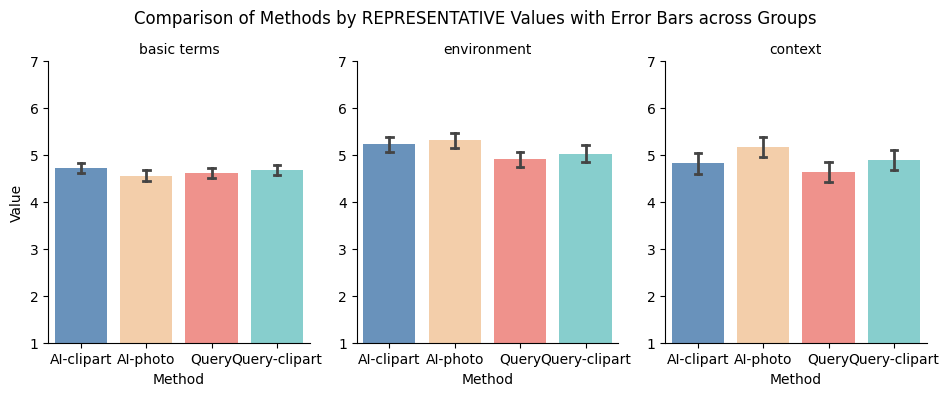

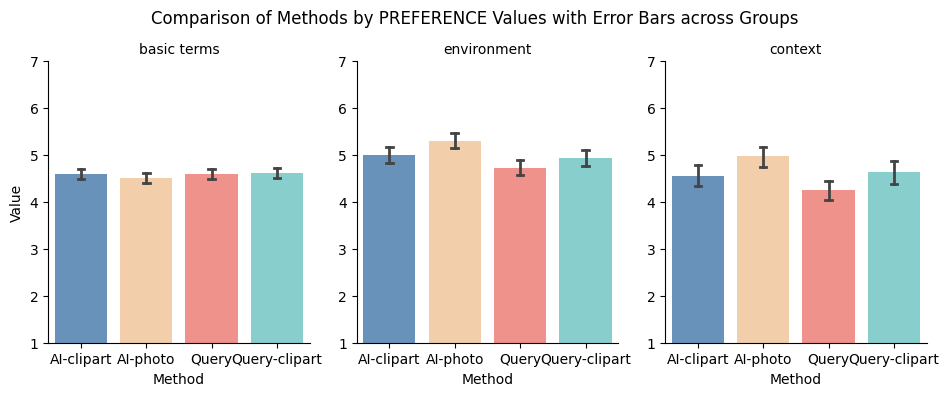


Representative:

############Group: basic terms ############
############ Mean ############
Method
AI-clipart       4.719697
AI-photo         4.550000
Query            4.610606
Query-clipart    4.677273
Name: Value, dtype: float64
############ Std ############
Method
AI-clipart       1.463332
AI-photo         1.467581
Query            1.374450
Query-clipart    1.413279
Name: Value, dtype: float64

############Group: environment ############
############ Mean ############
Method
AI-clipart       5.225000
AI-photo         5.308333
Query            4.904167
Query-clipart    5.020833
Name: Value, dtype: float64
############ Std ############
Method
AI-clipart       1.233850
AI-photo         1.256254
Query            1.272161
Query-clipart    1.412579
Name: Value, dtype: float64
ANOVA: F_onewayResult(statistic=4.8991398664707155, pvalue=0.00219944989771528)
AI-clipart significantely > Query p-value: 0.005 ** statistic 2.804571495001071
AI-photo significantely > Query p-value: 0.001 *** stat

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import f_oneway, ttest_ind

# 忽略所有警告
warnings.filterwarnings('ignore')

# 读取 Excel 文件
data = pd.read_excel('./rating.xlsx')

# 提取数值部分并转换为整数
data.iloc[:, 2] = data.iloc[:, 2].str.extract('(\d+)').astype(int)

# distribution of time :2
# print(data.iloc[:, 2].value_counts())
# histogram of time
# plt.hist(data.iloc[:, 2], bins=40)
# plt.show()
# 移除不符合条件的行
data = data[~data['序号'].isin([11, 13, 14, 19, 28, 40, 43, 45, 49, 50, 56, 59, 60])]
data = data[(data.iloc[:, 9] != '否') | (data.iloc[:, 2] >= 500)]
data = data[(data.iloc[:, 9] != '否') | (data.iloc[:, 2] <= 3000)]

#  mean data.iloc[:, 2]
print(data.iloc[:, 2].mean())

# 筛选设计师
# data = data[(data.iloc[:, 9] != '否')]
# 筛选非设计师
# data = data[(data.iloc[:, 9] != '是')]
print(data.shape)
# 统计有效的用户id
# print(data['序号'])
# 保留所需列
data = data.iloc[:, 7:]

# 提取性别、年龄和背景信息
gender = data.iloc[:, 0]
age = data.iloc[:, 1]
background = data.iloc[:, 2]
print(gender.value_counts())
# 计算年龄的平均值，标准差
print(age.mean(), age.std())
print(background.value_counts())

# 提取后面的数据
method_columns = ['AI-clipart', 'AI-photo', 'Query', 'Query-clipart']
metric_columns = ['Representative', 'Preference']
group_names = ['basic terms', 'environment', 'context']

# 准备数据框以存储重塑后的数据
reshaped_data = {'Method': [], 'Metric': [], 'Group': [], 'Value': []}

# 根据列索引的余数来判断列属于哪个方法和指标
for i in range(3, data.shape[1]):
    method_index = (i - 3) % 8 // 2
    metric_index = (i - 3) % 2
    cycle = (i - 3) // 8
    # 7,7,8,8,6
    if cycle < 22:
        group = group_names[0]
    elif cycle < 30:
        group = group_names[1]
    else:
        group = group_names[2]

    method = method_columns[method_index]
    metric = metric_columns[metric_index]

    reshaped_data['Method'].extend([method] * len(data))
    reshaped_data['Metric'].extend([metric] * len(data))
    reshaped_data['Group'].extend([group] * len(data))
    reshaped_data['Value'].extend(data.iloc[:, i])

# 转换成 DataFrame
reshaped_df = pd.DataFrame(reshaped_data)
overall = reshaped_df.copy()
# add a new group as overall
# print reshaped_df, group by method and metric, count of unique values
print(reshaped_df.groupby(['Method', 'Metric'])['Value'].nunique())
# wrtite to csv
reshaped_df.to_csv('./reshaped.csv', index=False)
# print(reshaped_df)

# 绘制图像
palette = ["#5b92c9", "#ffce9e", "#ff847c", "#7bdad9"]

for metric in metric_columns:

    metric_df = reshaped_df[reshaped_df['Metric'] == metric]
    # drop overall
    # metric_df = metric_df[metric_df['Group'] != 'Overall']

    g = sns.FacetGrid(metric_df, col='Group', col_wrap=3, height=4, sharex=False, sharey=False, aspect=0.8)
    g.map_dataframe(sns.barplot, x='Method', y='Value', ci=95, hue="Method", errcolor='#444', errwidth=2, capsize=0.1, order=method_columns, palette=palette)
    g.set(ylim=(1, 7))
    # g.add_legend(title='Method')
    # legend
    # g.add_legend(title='Method', labels=method_columns)
    g.set_axis_labels("Method", "Value")
    g.set_titles(col_template="{col_name}")
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(f'Comparison of Methods by {metric.upper()} Values with Error Bars across Groups')

    # save to svg
    save_path = f"./{metric}.svg"
    plt.savefig(save_path, format='svg', bbox_inches='tight')
    plt.show()


# 打印显著性
def print_significant(pair, p):
    # 

    pair_list = pair.split(' vs ')
    pair_list[0]
    G1 = pair_list[0]
    G2 = pair_list[1]
    text = ""
    if p[0] < 0:
        text = f"{G1} significantely < {G2}"
    else:
        text = f"{G1} significantely > {G2}"
    if p[1] < 0.001:
        print(f"{text} p-value: {p[1]:.3f} *** statistic {p[0]}")
    elif p[1] < 0.01:
        print(f"{text} p-value: {p[1]:.3f} ** statistic {p[0]}")
    elif p[1] < 0.05:
        print(f"{text} p-value: {p[1]:.3f} * statistic {p[0]}")
    else:
        return
        # print(f"{pair} p-value: {p[1]:.3f} statistic {p[0]}")


# 显著性检验
def significance_test(metric):
    print(f"\n{metric}:")
    for group in group_names + ['Overall']:
        print(f"\n############Group: {group} ############")
        group_df = reshaped_df[(reshaped_df['Metric'] == metric) & (reshaped_df['Group'] == group)]

        if group_df.empty:
            print("No data available for this group.")
            continue
        # print mean, std
        print("############ Mean ############")
        print(group_df.groupby('Method')['Value'].mean())
        print("############ Std ############")
        print(group_df.groupby('Method')['Value'].std())
        anova_result = f_oneway(group_df[group_df['Method'] == 'AI-clipart']['Value'], group_df[group_df['Method'] == 'AI-photo']['Value'],
                                group_df[group_df['Method'] == 'Query']['Value'], group_df[group_df['Method'] == 'Query-clipart']['Value'])

        if anova_result[1] < 0.05:
            print("ANOVA:", anova_result)
            for pair in [("AI-clipart", "AI-photo"), ("AI-clipart", "Query"), ("AI-clipart", "Query-clipart"), ("AI-photo", "Query"),
                         ("AI-photo", "Query-clipart"), ("Query", "Query-clipart")]:
                ttest_result = ttest_ind(group_df[group_df['Method'] == pair[0]]['Value'], group_df[group_df['Method'] == pair[1]]['Value'])
                print_significant(f"{pair[0]} vs {pair[1]}", ttest_result)


significance_test('Representative')
significance_test('Preference')